In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from datetime import datetime

from model_settings import ms
from feature_collector import collect_features, preprocess_data

os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)

# initializing

In [2]:
from convsklearn import barrier_trainer, asian_trainer
price_name = 'asian' 
filetag = 'short-term cboe asians'
trainer = asian_trainer
datadir = os.path.join(root,ms.cboe_spx_short_term_asians['dump'])

dataset = collect_features(datadir,price_name)
dates = pd.Series(np.sort(dataset['calculation_date'].unique()))

train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")
dates

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1461/1461 [00:00<00:00, 1678.97it/s]


##################
# training start #
##################

Fri Nov  1 18:04:32 2024



0      2024-06-21 16:10:47.398
1      2024-06-21 16:59:37.687
2      2024-06-24 11:21:54.206
3      2024-06-24 12:36:46.067
4      2024-06-24 12:36:55.095
                 ...          
1455   2024-10-15 14:26:15.994
1456   2024-10-15 14:31:59.764
1457   2024-10-15 15:57:40.633
1458   2024-10-15 16:14:27.028
1459   2024-10-15 16:50:04.131
Length: 1460, dtype: datetime64[ns]

In [3]:
dataset

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,asian,observed_price
0,5813.50000,2906.00000,7,1.00000,7,0,arithmetic,call,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2907.98401,2907.95705
1,5813.50000,7266.50000,28,1.00000,28,0,arithmetic,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,1439.52790,1439.56419
2,5813.50000,8720.00000,84,12.00000,7,0,arithmetic,call,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,0.00000,0.02833
3,5813.50000,8720.00000,84,12.00000,7,0,geometric,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2851.84717,2851.89585
4,5813.50000,7266.50000,84,12.00000,7,0,arithmetic,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,1408.25957,1408.28423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204319,5467.25000,4099.75000,84,1.00000,84,0,arithmetic,put,0.04000,0.00000,2024-06-21 16:10:47.398,20.79920,0.02824,-0.43219,2.11409,0.00000,0.01470,0.02636
204320,5467.25000,5466.50000,84,1.00000,84,0,geometric,call,0.04000,0.00000,2024-06-21 16:10:47.398,20.79920,0.02824,-0.43219,2.11409,0.00000,81.97359,81.97751
204321,5467.25000,5466.50000,84,1.00000,84,0,geometric,put,0.04000,0.00000,2024-06-21 16:10:47.398,20.79920,0.02824,-0.43219,2.11409,0.00000,59.52628,59.53398
204322,5467.25000,5466.50000,84,1.00000,84,0,arithmetic,call,0.04000,0.00000,2024-06-21 16:10:47.398,20.79920,0.02824,-0.43219,2.11409,0.00000,83.00630,82.97710


# preprocessing

## train/test split

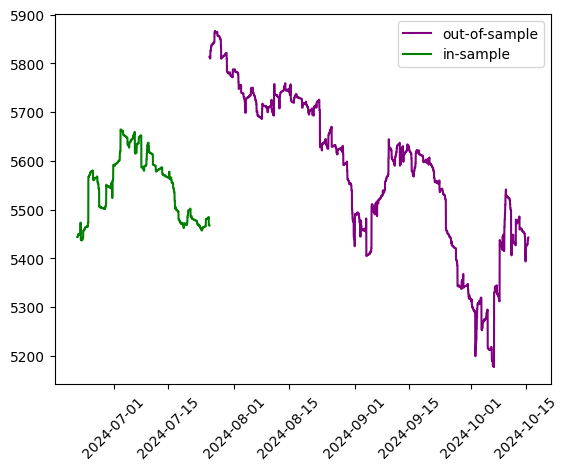

In [4]:
development_dates = dates[:len(dates)//4]
# development_dates = dates[dates<=pd.Timestamp(2008,8,1)]
test_dates = dates[~dates.isin(development_dates)]
preprocessed = preprocess_data(dataset,development_dates,test_dates,trainer)
train_test = preprocessed['train_test_arrays']
preprocessor = preprocessed['preprocessor']
train_X=train_test['train_X']
train_y=train_test['train_y']
test_X=train_test['test_X']
test_y=train_test['test_y']
train_data = preprocessed['train_data']
test_data = preprocessed['test_data']

In [5]:
model_fit = trainer.run_dnn(preprocessor,train_X,train_y)
train_test = trainer.test_prediction_accuracy(train_data,test_data,model_fit)
train_data = train_test['train_data']
test_data = train_test['test_data']


training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 2.522444248199463

in sample:
     RMSE: 7.9599411258557495
     MAE: 4.843535383778584

out of sample:
     RMSE: 35.233854166868134
     MAE: 17.753993674563237


In [6]:
test_data

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,asian,observed_price,outofsample_target,outofsample_prediction,outofsample_error
0,5813.50000,2906.00000,7,1.00000,7,0,arithmetic,call,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2907.98401,2907.95705,2907.95705,2902.45755,-5.49950
1,5813.50000,7266.50000,28,1.00000,28,0,arithmetic,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,1439.52790,1439.56419,1439.56419,1452.36148,12.79730
2,5813.50000,8720.00000,84,12.00000,7,0,arithmetic,call,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,0.00000,0.02833,0.02833,31.97058,31.94225
3,5813.50000,8720.00000,84,12.00000,7,0,geometric,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,2851.84717,2851.89585,2851.89585,2795.91050,-55.98535
4,5813.50000,7266.50000,84,12.00000,7,0,arithmetic,put,0.04000,0.00000,2024-10-15 16:50:04.131,1.98223,0.08750,-0.65710,1.70557,0.01895,1408.25957,1408.28423,1408.28423,1437.75786,29.47363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154234,5442.75000,8164.00000,84,3.00000,28,0,geometric,put,0.04000,0.00000,2024-07-25 15:35:00.352,4.44301,0.04258,-0.57580,2.04703,0.02714,2674.68055,2674.67260,2674.67260,2675.74238,1.06979
154235,5442.75000,8164.00000,84,3.00000,28,0,geometric,call,0.04000,0.00000,2024-07-25 15:35:00.352,4.44301,0.04258,-0.57580,2.04703,0.02714,0.00000,0.01785,0.01785,11.08336,11.06551
154236,5442.75000,6803.25000,84,3.00000,28,0,arithmetic,call,0.04000,0.00000,2024-07-25 15:35:00.352,4.44301,0.04258,-0.57580,2.04703,0.02714,0.01824,0.01519,0.01519,4.75305,4.73786
154237,5442.75000,6803.25000,28,1.00000,28,0,geometric,put,0.04000,0.00000,2024-07-25 15:35:00.352,4.44301,0.04258,-0.57580,2.04703,0.02714,1348.90443,1348.88297,1348.88297,1351.29917,2.41619


# saving

In [7]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    n_calls = train_data[train_data['w']=='call'].shape[0]
    n_puts = train_data[train_data['w']=='put'].shape[0]
    train_data.to_csv(f"{file_dir} train_data.csv")
    test_data.to_csv(f"{file_dir} test_data.csv")
    joblib.dump(model_fit,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_11_01 180435470848 short-term cboe asians

cpu: 2.698291063308716
